****Part II**** - Select only 0-9 training images from the dataset, and
use the pretrained network to train on MNIST dataset. Use the [standard
MNIST train and test splits](http://yann.lecun.com/exdb/mnist/). How
does this pretrained network perform in comparison to a randomly
initialized network in terms of convergence time, final accuracy and
other possible training quality metrics? Do a thorough analysis. Please
save your model checkpoints.

****Refactoring****

In order to plug in different datasets and make experimenting easier, I
refactored the code to make use of `argparse` to pass in command line
arguments to select a dataset, whether or not to use a pretrained model
and so on.

For the first step of Task 2.1, I added a flag `numbers_only` which
indicated whether to use the full NumbersAndLetters dataset or only 0-9
classes. Finally, we train using the architecture from Task2.1

`5conv1fc_drop_10x_blur&rotate&jitter&affine_cross-ent-weight`

In [ ]:
import os
import argparse

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from numbers_and_letters import NumbersAndLettersCNN, NumbersAndLettersModule
from mnist import MNISTModule

SAVE_PATH = "models/"
MODEL_NAME = '5conv1fc_numbers'
BATCH_SIZE = 32
NUMBERS_ONLY = True

BASE_DIR = "train"
INPUT_DIM = torch.tensor([3, 900, 1200])

# Create DataModule to handle loading of dataset
data_module = NumbersAndLettersModule(BASE_DIR, BATCH_SIZE, NUMBERS_ONLY)
model = NumbersAndLettersCNN(INPUT_DIM, len(data_module.img_labels),
                                data_module.img_labels, NUMBERS_ONLY)

# Log metrics to WandB
wandb_logger = pl.loggers.WandbLogger(save_dir='logs/',
                                        name=MODEL_NAME,
                                        project='midas-task-2')
early_stopping = EarlyStopping(
    monitor='val_loss',
)

trainer = pl.Trainer(gpus=1, logger=wandb_logger,
                     callbacks=[early_stopping], min_epochs=5)
trainer.fit(model, data_module)
trainer.test(model=model, datamodule=data_module)

# Save model
torch.save(model.state_dict(), os.path.join(SAVE_PATH, MODEL_NAME))


****Summary****

|                     |                                                       |
|---------------------|-------------------------------------------------------|
| **Metric**          | **Result**                                            |
| Test Accuracy (%)   | 70.54                                                 |
| Epochs trained      | 32                                                    |
| Training time (min) | 0m 22s                                                |
| Confusion Matrix    | 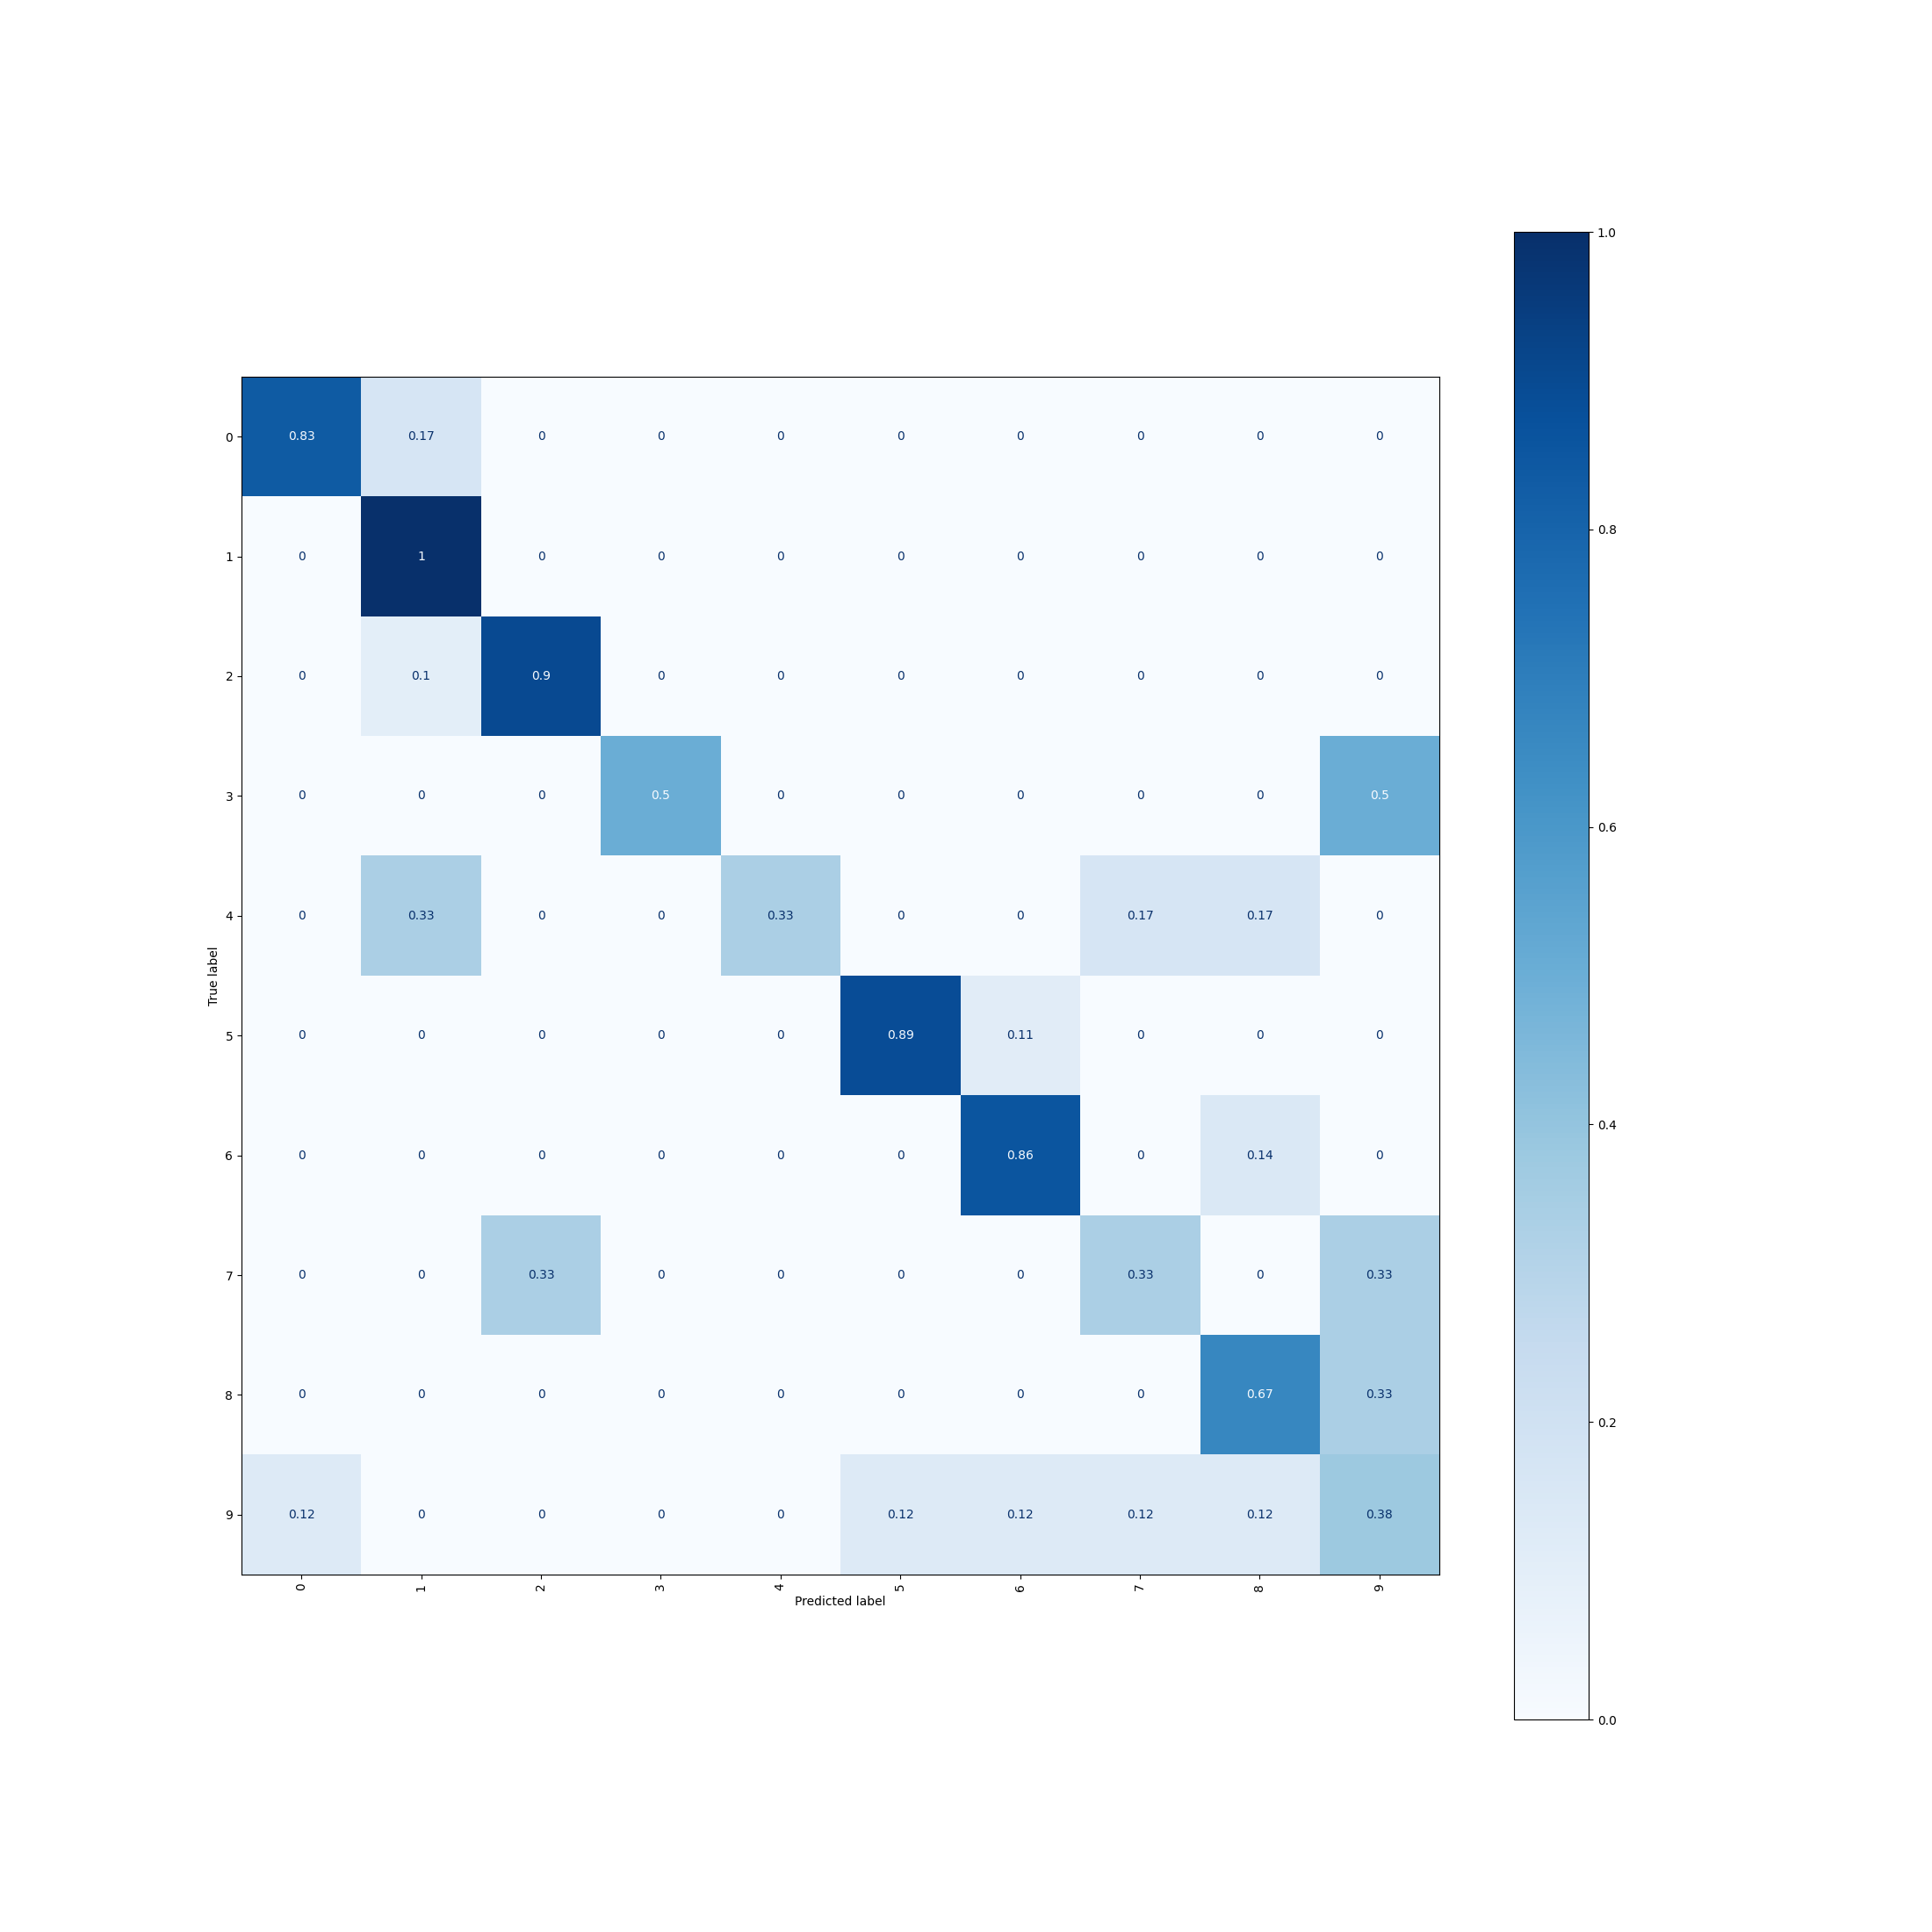 |

After being trained, the model has been stored in `5conv1fc_numbers`,
where it will loaded for the next round of training on the MNIST
dataset. PyTorch provides an MNIST dataset for easy use which I have
made use of.

Since there is a large amount of available data available, the
`min_epochs` and the `patience` arguments have been removed, to prevent
overfitting.

In [ ]:

MODEL_NAME = '5conv1fc_mnist_pretrained'
LOAD_MODEL_NAME = '5conv1fc_numbers'
data_module = MNISTModule(BATCH_SIZE)
INPUT_DIM = torch.tensor([1, 28, 28])
model = NumbersAndLettersCNN(INPUT_DIM, 10, ['0','1','2','3','4',
                                                '5','6','7','8','9'], NUMBERS_ONLY)
# Log metrics to WandB
wandb_logger = pl.loggers.WandbLogger(save_dir='logs/',
                                        name=MODEL_NAME,
                                        project='midas-task-2')
early_stopping = EarlyStopping(
    monitor='val_loss',
)

# Load pretrained model
model.load_state_dict(torch.load(os.path.join(SAVE_PATH, LOAD_MODEL_NAME),
                                     map_location=torch.device('cuda')))

trainer = pl.Trainer(gpus=1, logger=wandb_logger,
                     callbacks=[early_stopping])
trainer.fit(model, data_module)
trainer.test(model=model, datamodule=data_module)

# Save model
torch.save(model.state_dict(), os.path.join(SAVE_PATH, MODEL_NAME))


****Summary****

|                     |                                                               |
|---------------------|---------------------------------------------------------------|
| **Metric**          | **Result**                                                    |
| Test Accuracy (%)   | 96.2                                                          |
| Epochs trained      | 8                                                             |
| Training time (min) | 9m 42s                                                        |
| Confusion Matrix    | 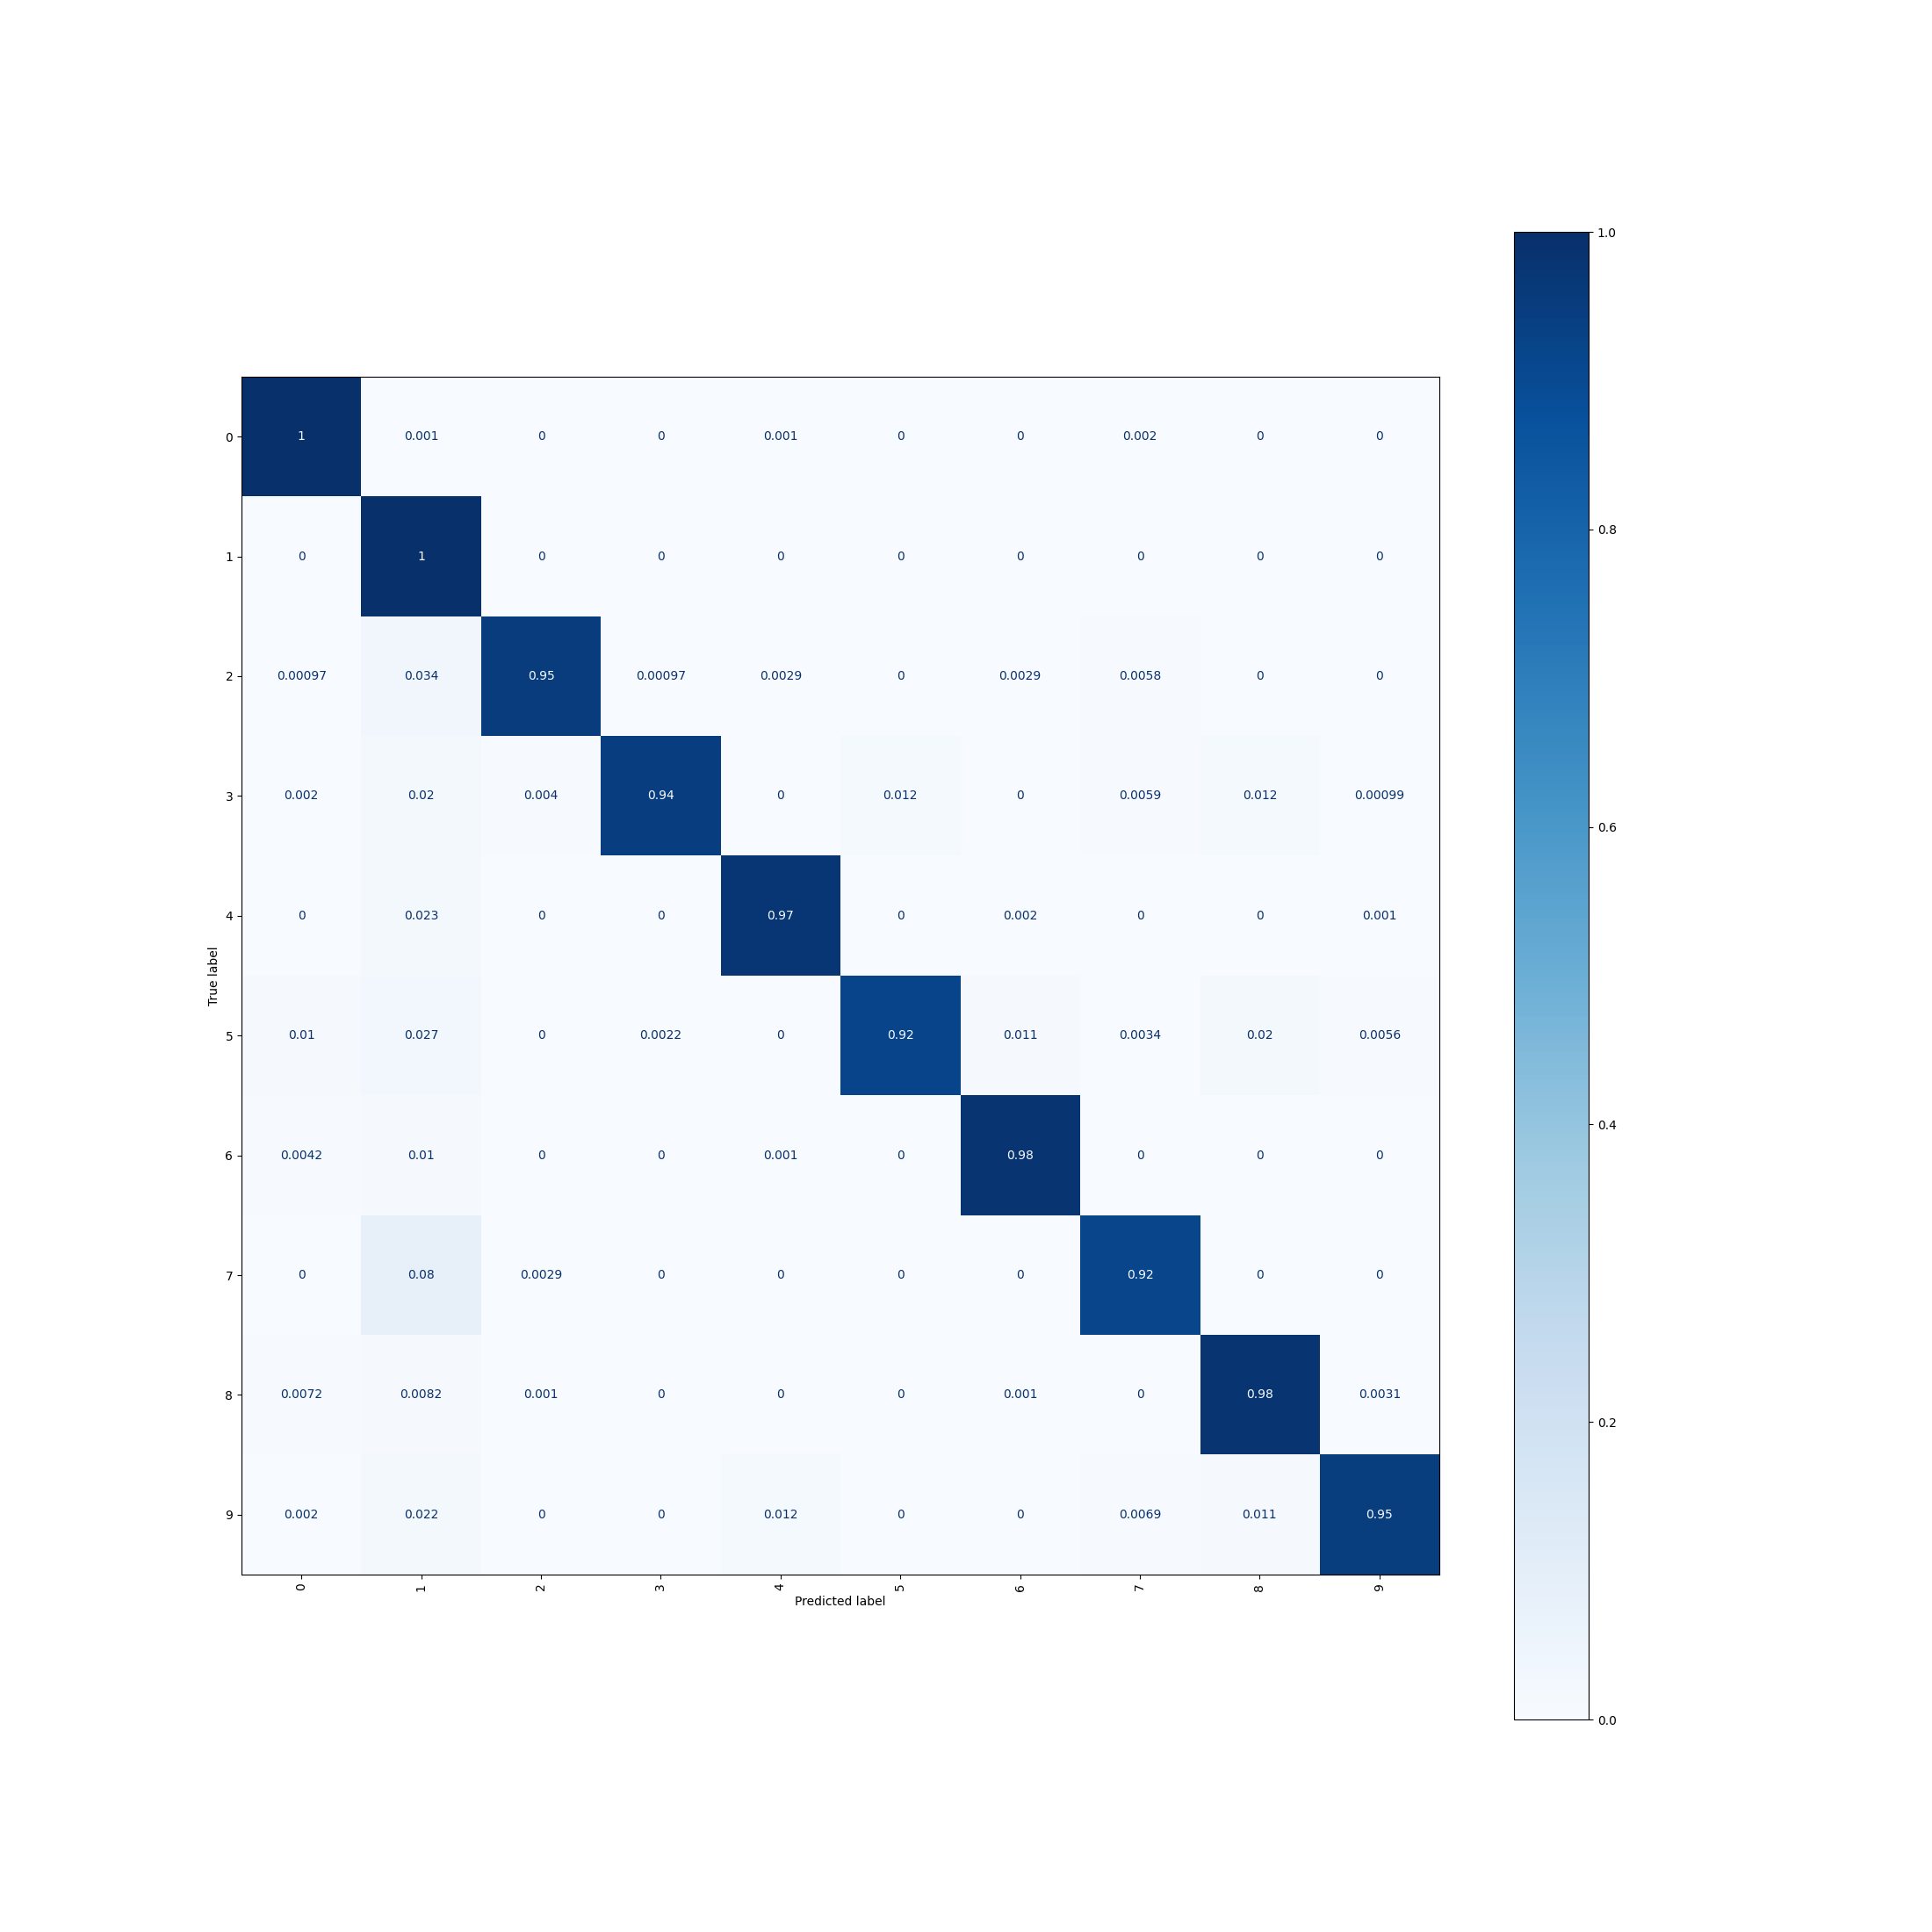 |

As expected, the network makes good use of the MNIST data and learns
very well, with a classification accuracy of **96.2%**. The number of
epochs trained are lesser, which is due to the fact that the amount of
data available is now is around 120x more. Correspondingly the training
time has only increased significantly

For the last part of this task, we compare the model with one that has
not been pretrained i.e. randomly initialized.

In [ ]:

MODEL_NAME = '5conv1fc_mnist'
data_module = MNISTModule(BATCH_SIZE)
INPUT_DIM = torch.tensor([1, 28, 28])
model = NumbersAndLettersCNN(INPUT_DIM, 10, ['0','1','2','3','4',
                                                '5','6','7','8','9'], NUMBERS_ONLY)
# Log metrics to WandB
wandb_logger = pl.loggers.WandbLogger(save_dir='logs/',
                                        name=MODEL_NAME,
                                        project='midas-task-2')
early_stopping = EarlyStopping(
    monitor='val_loss',
)

trainer = pl.Trainer(gpus=1, logger=wandb_logger,
                     callbacks=[early_stopping])
trainer.fit(model, data_module)
trainer.test(model=model, datamodule=data_module)

# Save model
torch.save(model.state_dict(), os.path.join(SAVE_PATH, MODEL_NAME))


****Summary****

|                     |                                                    |
|---------------------|----------------------------------------------------|
| **Metric**          | **Result**                                         |
| Test Accuracy (%)   | 83.76                                              |
| Epochs trained      | 11                                                 |
| Training time (min) | 11m 14s                                            |
| Confusion Matrix    | 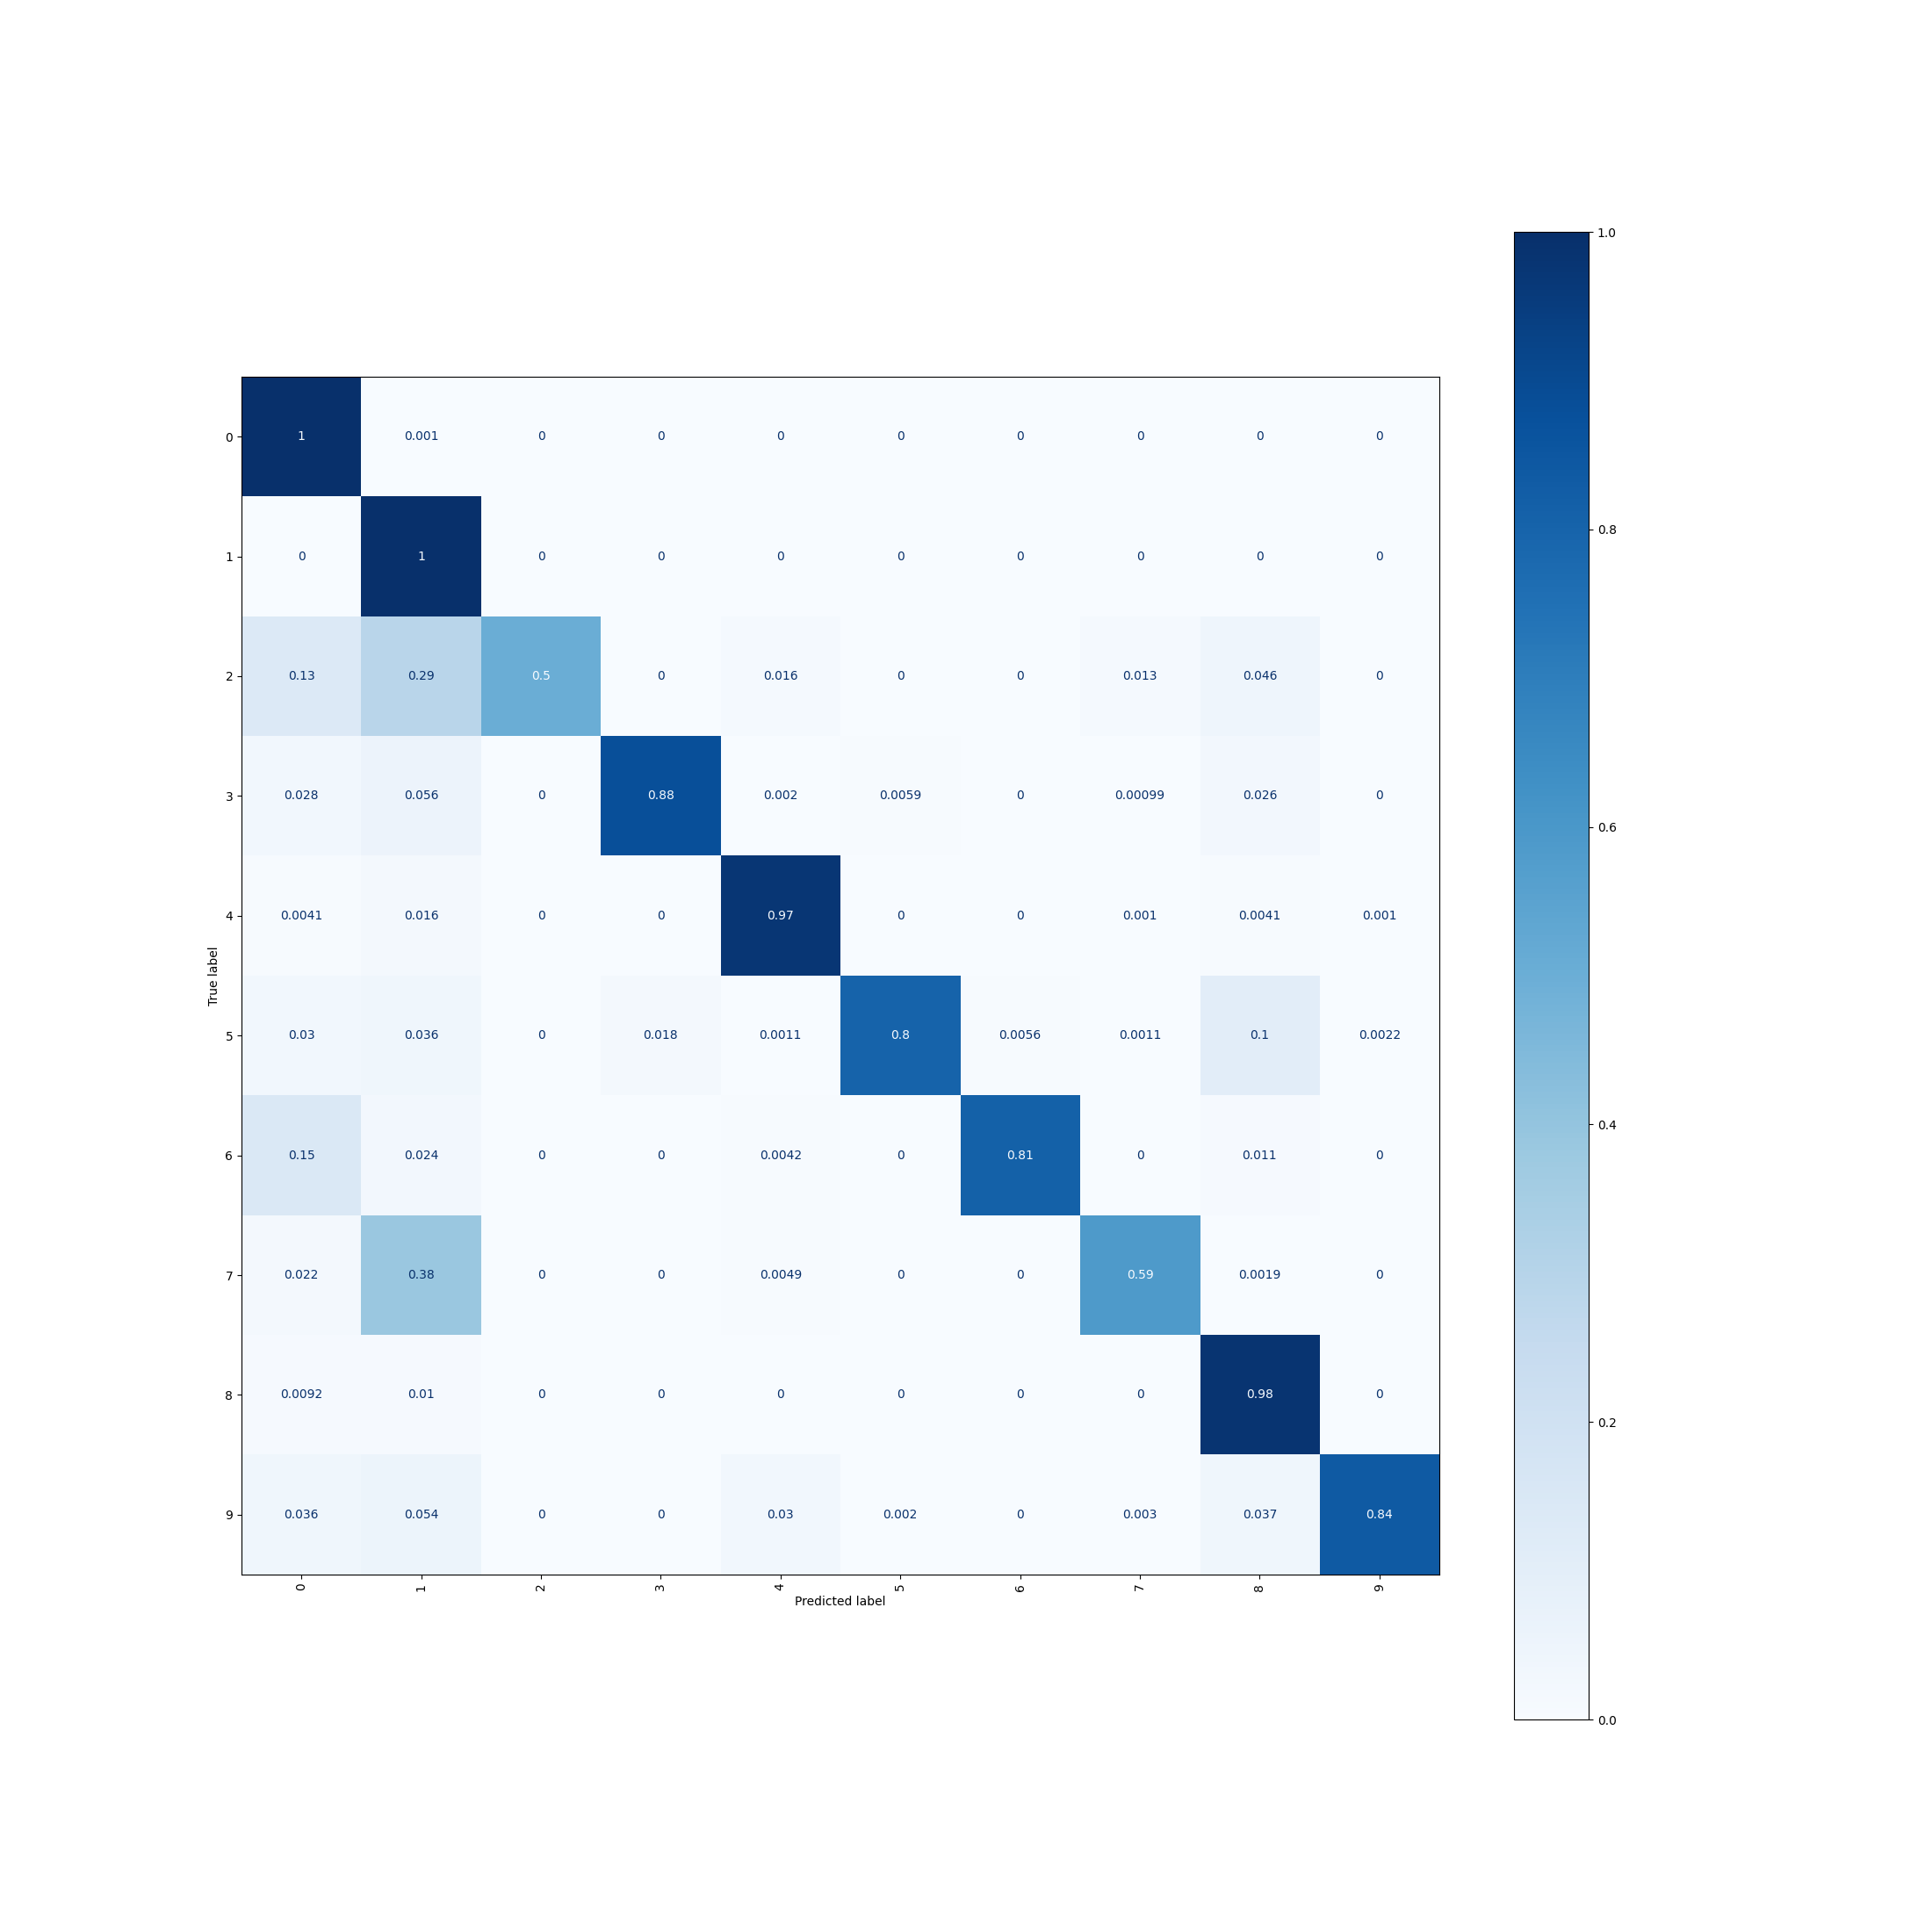 |

Initializing the network randomly led to a much worse performance across
all metrics, taking longer to train and still performing worse than the
pretrained model.

However, from the graphs we can see that the train loss and the
validation accuracy keep in pace with the pretrained model, albeit being
noisier. Thus we can conclude that while pretraining does not
significantly affect the end result, it does affect the **stability** of
the model, training more smoothly without disruptions.

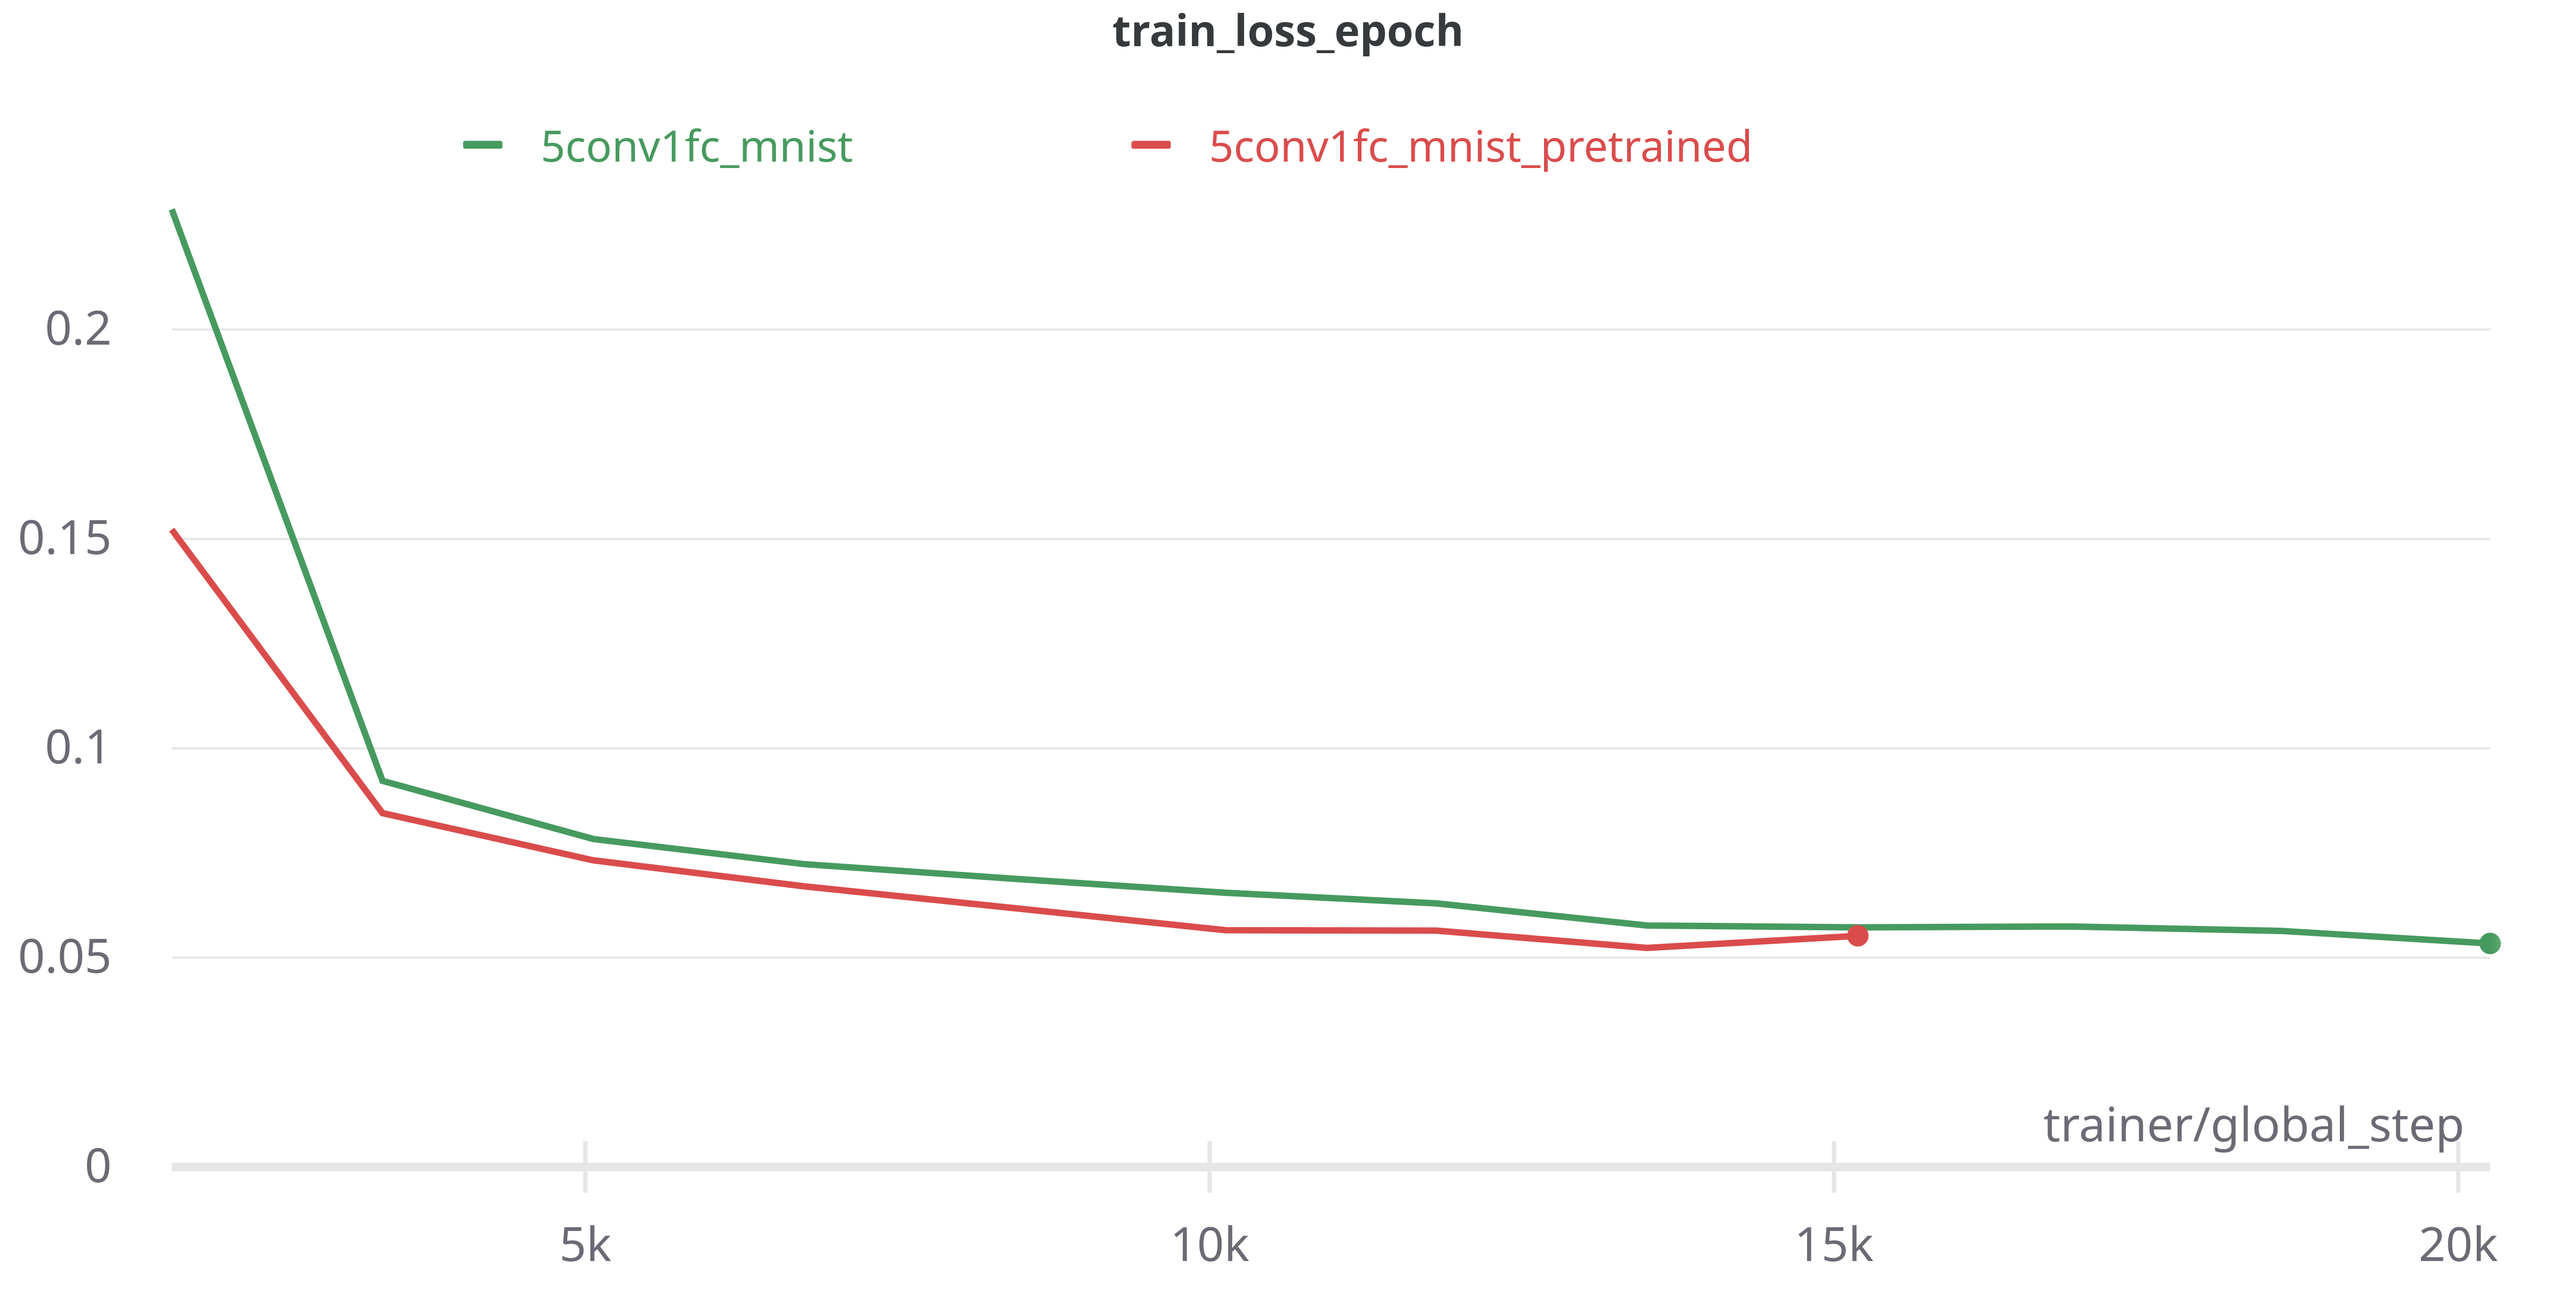

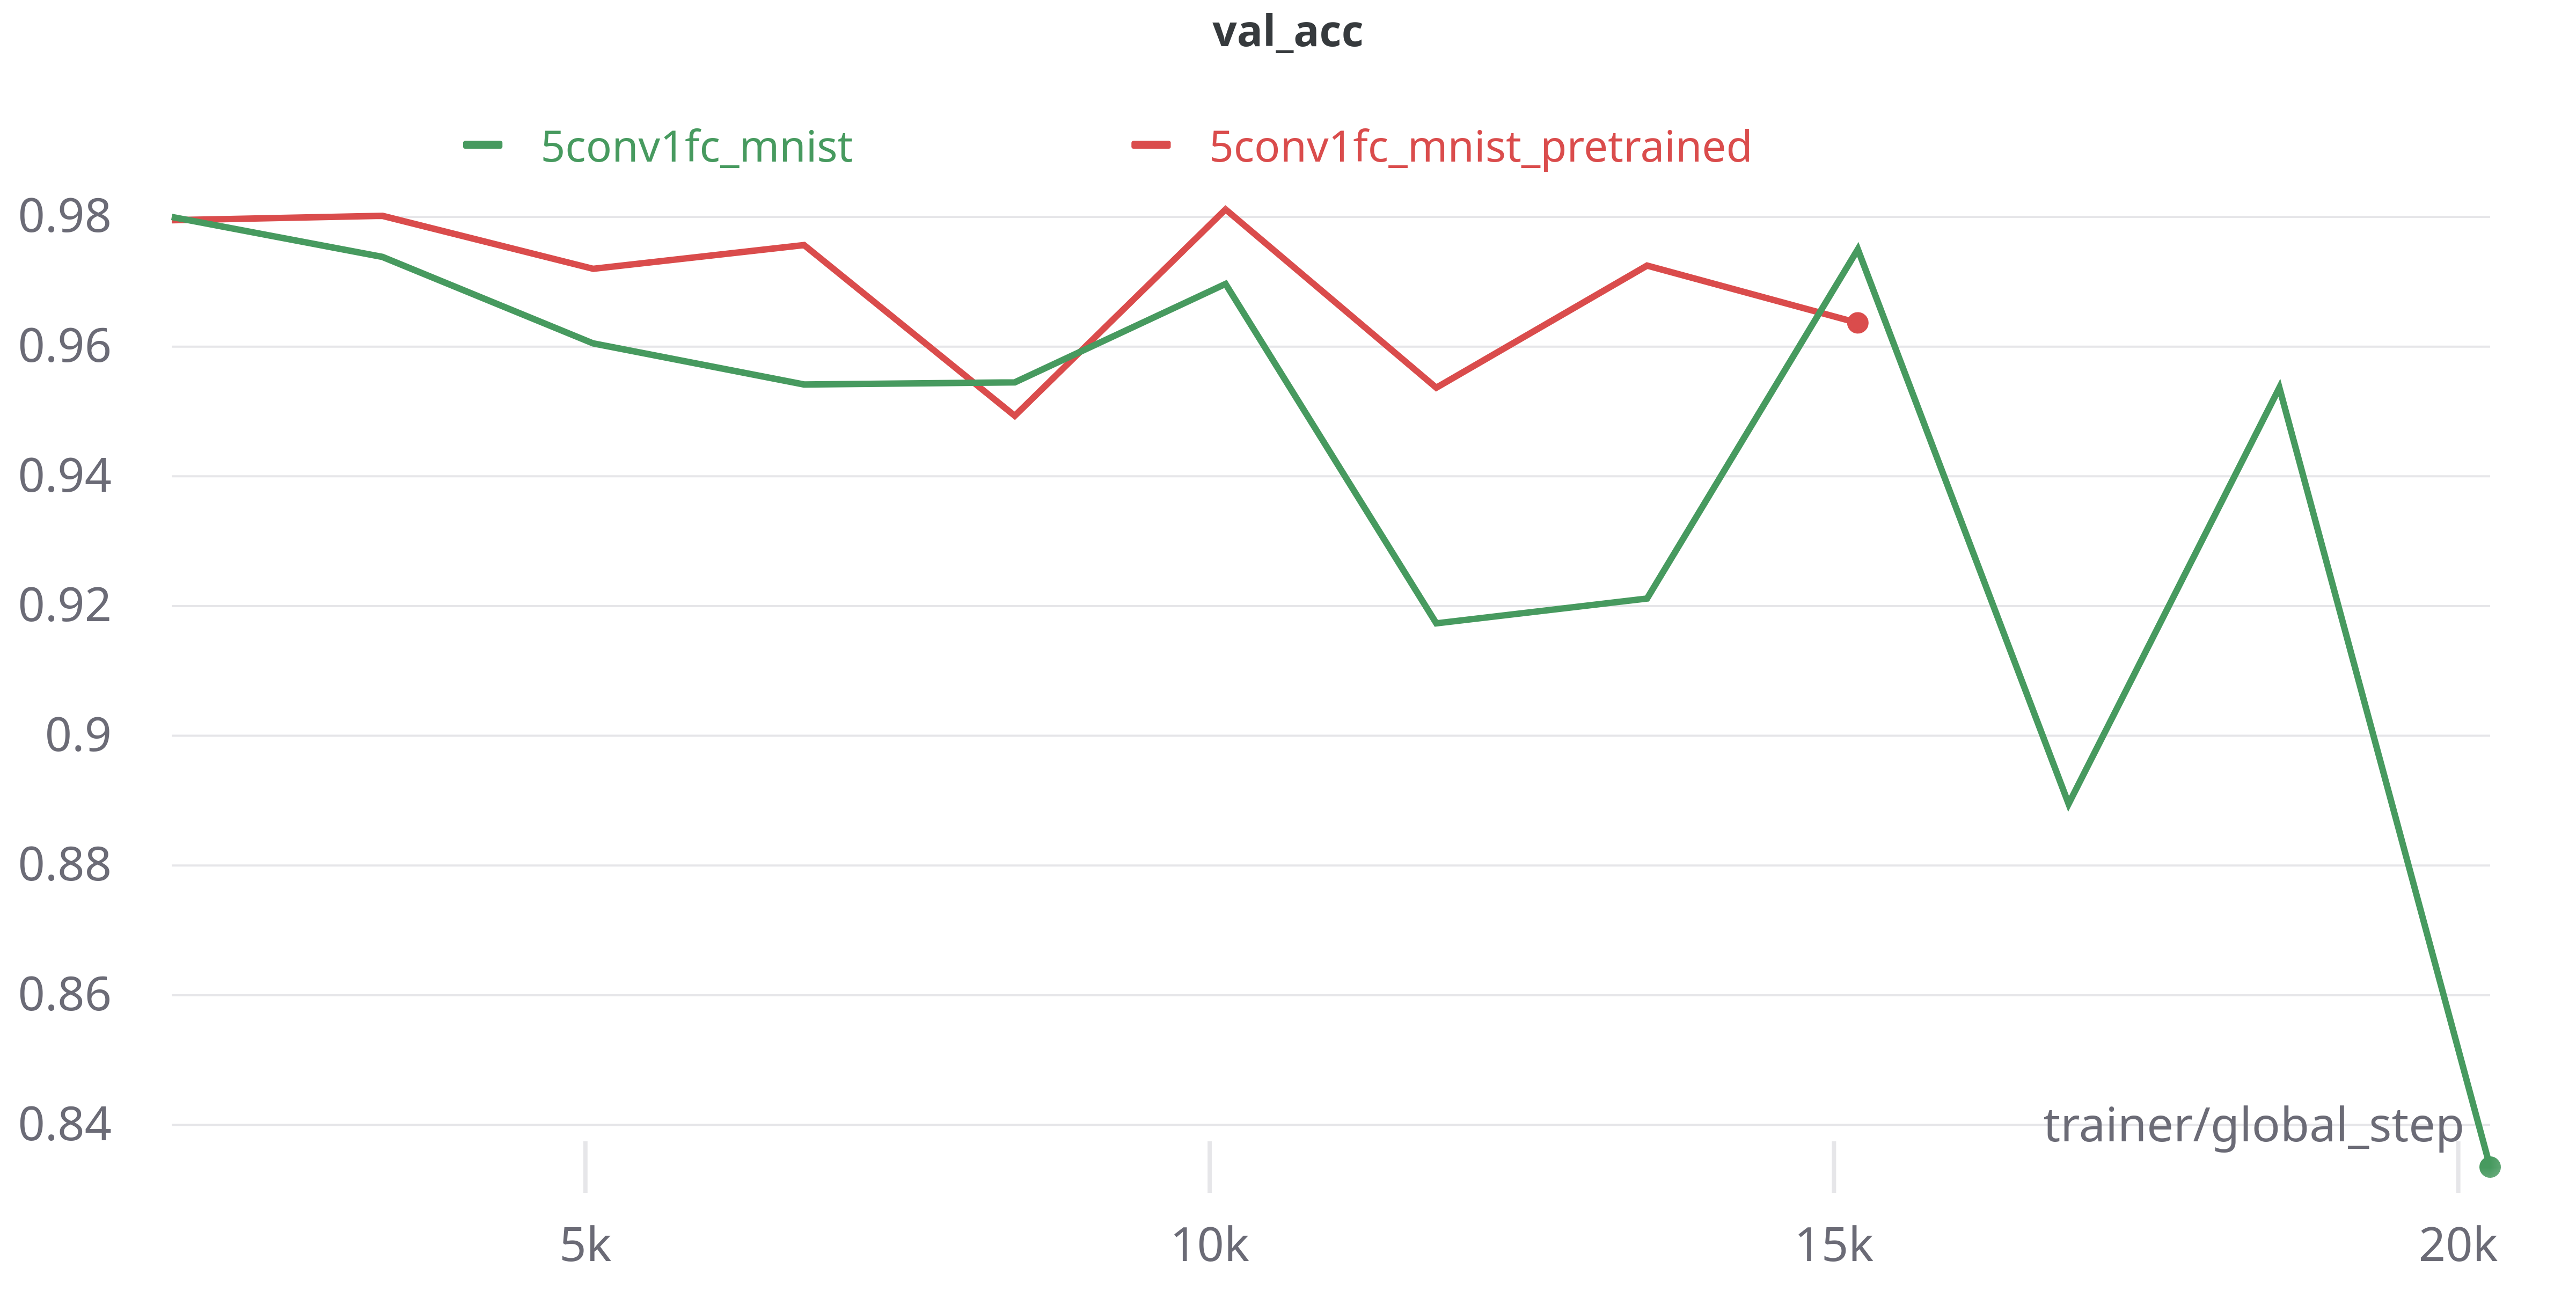